In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, hamming_loss
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
import seaborn as sns

print("TensorFlow version:", tf.__version__)
print("All libraries imported successfully!")

TensorFlow version: 2.18.1
All libraries imported successfully!


In [2]:
csv_file = "train.csv"
images_folder = "Images"

print("Checking files...")
print(f"CSV file exists: {os.path.exists(csv_file)}")
print(f"Images folder exists: {os.path.exists(images_folder)}")

if os.path.exists(images_folder):
    image_files = os.listdir(images_folder)
    # Filter out non-jpg files
    jpg_files = [f for f in image_files if f.endswith('.jpg')]
    print(f"Number of JPG image files: {len(jpg_files)}")
    print(f"First 5 image files: {jpg_files[:5]}")

if os.path.exists(csv_file):
    df_check = pd.read_csv(csv_file)
    print(f"CSV has {len(df_check)} rows and {len(df_check.columns)} columns")
    print(f"Column names: {list(df_check.columns)}")
    print("\nFirst few rows:")
    print(df_check.head())

Checking files...
CSV file exists: True
Images folder exists: True
Number of JPG image files: 7867
First 5 image files: ['tt0084058.jpg', 'tt0084867.jpg', 'tt0085121.jpg', 'tt0085154.jpg', 'tt0085159.jpg']
CSV has 7254 rows and 27 columns
Column names: ['Id', 'Genre', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'N/A', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']

First few rows:
          Id                                Genre  Action  Adventure  \
0  tt0086425                  ['Comedy', 'Drama']       0          0   
1  tt0085549        ['Drama', 'Romance', 'Music']       0          0   
2  tt0086465                           ['Comedy']       0          0   
3  tt0086567               ['Sci-Fi', 'Thriller']       0          0   
4  tt0086034  ['Action', 'Adventure', 'Thriller']       1          1   

   Animation  Biog

In [26]:
class MovieGenreClassifier:
    def __init__(self, image_size=(224, 224), batch_size=32):
        self.image_size = image_size
        self.batch_size = batch_size
        self.model = None
        self.class_names = None
        self.history = None
        
    def load_and_preprocess_data(self, csv_path, images_folder):
        """Load CSV data and prepare image paths"""
        # Load the CSV file
        df = pd.read_csv(csv_path)
        print(f"Loaded {len(df)} records from CSV")
        
        # Get genre columns (all the genres from your dataset, excluding N/A)
        genre_columns = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 
                        'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 
                        'History', 'Horror', 'Music', 'Musical', 'Mystery', 
                        'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 
                        'Sport', 'Thriller', 'War', 'Western']
        
        # Filter to only include rows where corresponding image exists
        valid_rows = []
        for idx, row in df.iterrows():
            image_path = os.path.join(images_folder, f"{row['Id']}.jpg")
            if os.path.exists(image_path):
                valid_rows.append(idx)
        
        df = df.loc[valid_rows].reset_index(drop=True)
        print(f"Found {len(df)} records with corresponding images")
        
        # Create image paths
        df['image_path'] = df['Id'].apply(lambda x: os.path.join(images_folder, f"{x}.jpg"))
        
        self.class_names = genre_columns
        return df, genre_columns
    
    def analyze_dataset(self, df, genre_columns):
        """Analyze the dataset distribution"""
        print("\n=== Dataset Analysis ===")
        print(f"Total samples: {len(df)}")
        
        # Genre distribution
        genre_counts = df[genre_columns].sum().sort_values(ascending=False)
        print(f"\nGenre distribution:")
        for genre, count in genre_counts.items():
            percentage = (count / len(df)) * 100
            print(f"{genre}: {count} ({percentage:.1f}%)")
        
        # Multi-label statistics
        labels_per_sample = df[genre_columns].sum(axis=1)
        print(f"\nLabels per sample:")
        print(f"Average: {labels_per_sample.mean():.2f}")
        print(f"Min: {labels_per_sample.min()}")
        print(f"Max: {labels_per_sample.max()}")
        
        # Plot genre distribution
        plt.figure(figsize=(15, 8))
        genre_counts.plot(kind='bar')
        plt.title('Genre Distribution in Dataset')
        plt.xlabel('Genre')
        plt.ylabel('Number of Movies')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        return genre_counts
    
    def create_data_generator(self, df, genre_columns, subset_type='training'):
        """Create data generator for training/validation"""
        def data_generator():
            for idx, row in df.iterrows():
                # Load and preprocess image
                img = Image.open(row['image_path']).convert('RGB')
                img = img.resize(self.image_size)
                img_array = np.array(img) / 255.0  # Normalize to [0,1]
                
                # Get labels
                labels = row[genre_columns].values.astype(np.float32)
                
                yield img_array, labels
        
        return data_generator
    
    def build_model(self, num_classes):
        """Build the model using transfer learning with ResNet50"""
        from tensorflow.keras.applications import ResNet50
        
        # Base model - using ResNet50
        base_model = ResNet50(
            input_shape=(*self.image_size, 3),
            include_top=False,
            weights='imagenet'
        )
        
        # Freeze base model initially
        base_model.trainable = False
        
        # Add custom classification head
        model = keras.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dropout(0.3),
            layers.Dense(512, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.4),
            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(num_classes, activation='sigmoid')  # Sigmoid for multi-label
        ])
        
        # Compile model
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['binary_accuracy']
        )
        
        self.model = model
        return model
    
    def train_model(self, train_df, val_df, genre_columns, epochs=10):
        """Train the model - CORRECTED with .repeat() and 10 epochs default"""
        # Create data generators
        train_gen = self.create_data_generator(train_df, genre_columns, 'training')
        val_gen = self.create_data_generator(val_df, genre_columns, 'validation')
        
        # Create TensorFlow datasets with .repeat() to fix the warning
        train_dataset = tf.data.Dataset.from_generator(
            train_gen,
            output_signature=(
                tf.TensorSpec(shape=(*self.image_size, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(len(genre_columns),), dtype=tf.float32)
            )
        ).batch(self.batch_size).repeat().prefetch(tf.data.AUTOTUNE)
        
        val_dataset = tf.data.Dataset.from_generator(
            val_gen,
            output_signature=(
                tf.TensorSpec(shape=(*self.image_size, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(len(genre_columns),), dtype=tf.float32)
            )
        ).batch(self.batch_size).repeat().prefetch(tf.data.AUTOTUNE)
        
        # Callbacks
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-7
            )
        ]
        
        # Train the model
        steps_per_epoch = len(train_df) // self.batch_size
        validation_steps = len(val_df) // self.batch_size
        
        print(f"Starting initial training for {epochs} epochs...")
        self.history = self.model.fit(
            train_dataset,
            steps_per_epoch=steps_per_epoch,
            validation_data=val_dataset,
            validation_steps=validation_steps,
            epochs=epochs,
            callbacks=callbacks
        )
        
        # Fine-tuning phase - CHANGED TO 10 EPOCHS
        print("Starting fine-tuning phase...")
        self.model.layers[0].trainable = True
        
        # Lower learning rate for fine-tuning
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss='binary_crossentropy',
            metrics=['binary_accuracy']
        )
        
        # Continue training with fine-tuning - 10 epochs instead of 20
        fine_tune_epochs = 10
        print(f"Fine-tuning for {fine_tune_epochs} epochs...")
        history_fine = self.model.fit(
            train_dataset,
            steps_per_epoch=steps_per_epoch,
            validation_data=val_dataset,
            validation_steps=validation_steps,
            epochs=fine_tune_epochs,
            callbacks=callbacks
        )
        
        return self.history

    def predict(self, df):
        """
        Predict genres for multiple images in a dataframe
        
        Args:
            df: DataFrame containing 'image_path' column
            
        Returns:
            numpy array of predictions with shape (n_samples, n_classes)
        """
        # Create a list to store predictions
        all_predictions = []
        
        # Process images in batches
        for i in tqdm(range(0, len(df), self.batch_size)):
            batch_df = df.iloc[i:i+self.batch_size]
            batch_images = []
            
            # Load and preprocess each image in the batch
            for _, row in batch_df.iterrows():
                img = Image.open(row['image_path']).convert('RGB')
                img = img.resize(self.image_size)
                img_array = np.array(img) / 255.0  # Normalize to [0,1]
                batch_images.append(img_array)
        
            # Convert to numpy array
            batch_images = np.array(batch_images)
        
            # Get predictions for the batch
            batch_predictions = self.model.predict(batch_images, verbose=0)
            all_predictions.extend(batch_predictions)
        
        return np.array(all_predictions)
    
    def evaluate_model(self, test_df, genre_columns, threshold=0.5):
        """
        Evaluate the model on test data
        """
        # Get predictions
        predictions = self.predict(test_df)
        
        # Get true labels
        true_labels = test_df[genre_columns].values
        
        # Convert predictions to binary format
        binary_predictions = (predictions > threshold).astype(int)
        
        # Ensure both arrays have the same format
        # This is the key fix - make sure both are in the same format
        if true_labels.shape != binary_predictions.shape:
            print(f"Warning: Shape mismatch - true_labels: {true_labels.shape}, predictions: {binary_predictions.shape}")
            # If needed, reshape to match
        
        # Check for any NaN values
        if np.isnan(true_labels).any() or np.isnan(binary_predictions).any():
            print("Warning: NaN values detected in labels or predictions")
            # Replace NaN with 0
            true_labels = np.nan_to_num(true_labels)
            binary_predictions = np.nan_to_num(binary_predictions)
        
        # Calculate metrics
        hamming = hamming_loss(true_labels, binary_predictions)
        
        print(f"Hamming Loss: {hamming:.4f}")
        print(f"Average Accuracy per Sample: {1 - hamming:.4f}")
        
        # Return predictions and true labels for further analysis
        return predictions, true_labels, binary_predictions
    
    def predict_single_image(self, image_path, threshold=0.5):
        """Predict genres for a single image"""
        img = Image.open(image_path).convert('RGB')
        img = img.resize(self.image_size)
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        predictions = self.model.predict(img_array, verbose=0)[0]
        
        # Get predicted genres
        predicted_genres = []
        for i, prob in enumerate(predictions):
            if prob > threshold:
                predicted_genres.append((self.class_names[i], prob))
        
        return predicted_genres, predictions
    
    def plot_training_history(self):
        """Plot training history"""
        if self.history is None:
            print("No training history available")
            return
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        # Loss
        axes[0].plot(self.history.history['loss'], label='Training Loss')
        axes[0].plot(self.history.history['val_loss'], label='Validation Loss')
        axes[0].set_title('Model Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        
        # Accuracy
        axes[1].plot(self.history.history['binary_accuracy'], label='Training Accuracy')
        axes[1].plot(self.history.history['val_binary_accuracy'], label='Validation Accuracy')
        axes[1].set_title('Model Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()
        
        plt.tight_layout()
        plt.show()

print("MovieGenreClassifier class defined!")

MovieGenreClassifier class defined!


In [4]:
classifier = MovieGenreClassifier(image_size=(224, 224), batch_size=16)

# Load and analyze the data
csv_path = "train.csv"
images_folder = "Images"

print("Loading data...")
df, genre_columns = classifier.load_and_preprocess_data(csv_path, images_folder)

print(f"\nGenres we're working with: {genre_columns}")
print(f"Total number of genres: {len(genre_columns)}")

Loading data...
Loaded 7254 records from CSV
Found 7254 records with corresponding images

Genres we're working with: ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']
Total number of genres: 24


Analyzing dataset...

=== Dataset Analysis ===
Total samples: 7254

Genre distribution:
Drama: 3619 (49.9%)
Comedy: 2900 (40.0%)
Action: 1343 (18.5%)
Romance: 1334 (18.4%)
Crime: 1176 (16.2%)
Thriller: 918 (12.7%)
Adventure: 870 (12.0%)
Documentary: 652 (9.0%)
Horror: 503 (6.9%)
Fantasy: 467 (6.4%)
Mystery: 454 (6.3%)
Biography: 441 (6.1%)
Family: 434 (6.0%)
Sci-Fi: 399 (5.5%)
Music: 305 (4.2%)
Animation: 244 (3.4%)
History: 224 (3.1%)
Sport: 221 (3.0%)
War: 144 (2.0%)
Musical: 97 (1.3%)
Western: 50 (0.7%)
Short: 46 (0.6%)
News: 21 (0.3%)
Reality-TV: 2 (0.0%)

Labels per sample:
Average: 2.32
Min: 0
Max: 3


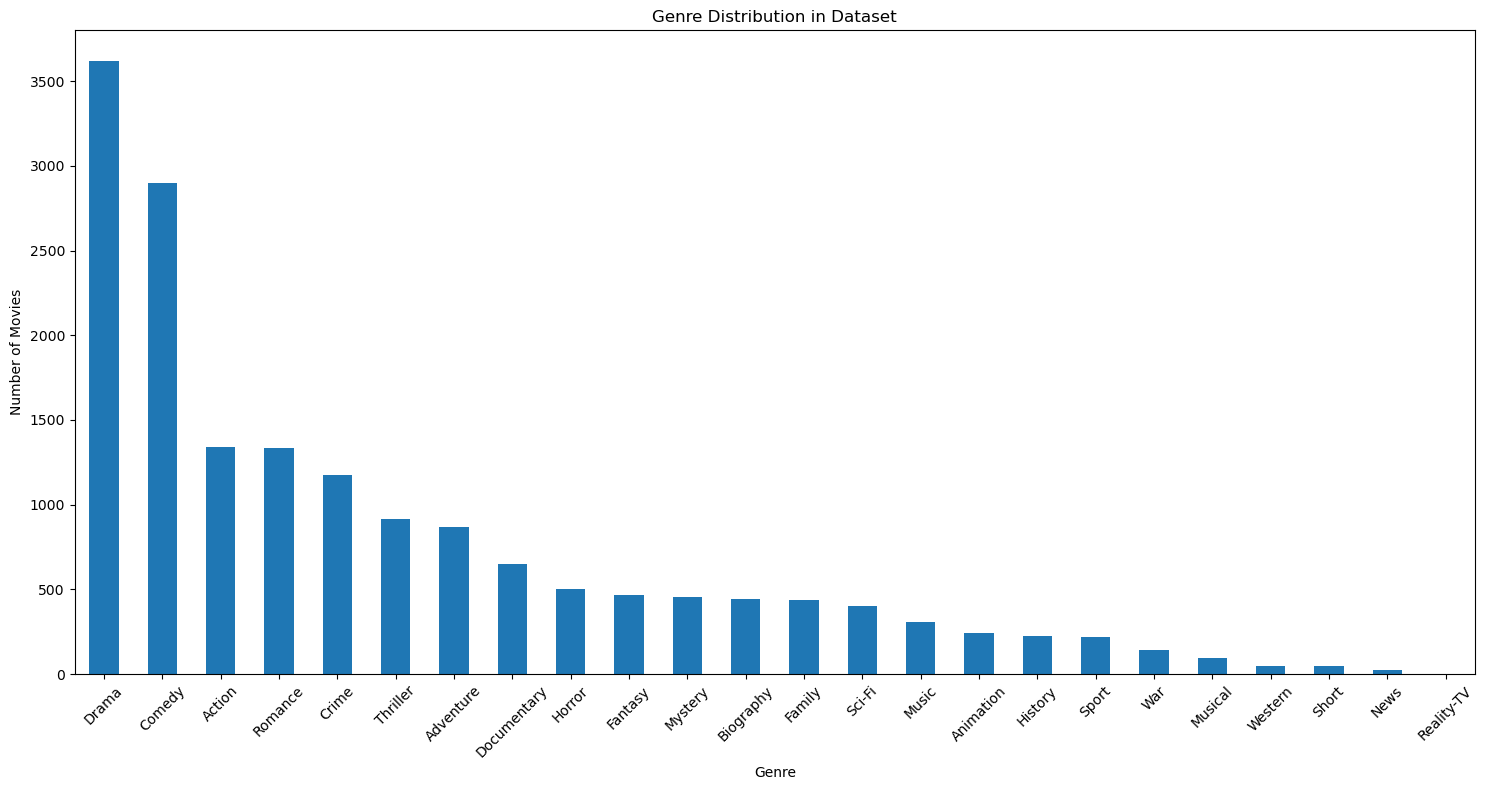

In [5]:
print("Analyzing dataset...")
genre_counts = classifier.analyze_dataset(df, genre_columns)

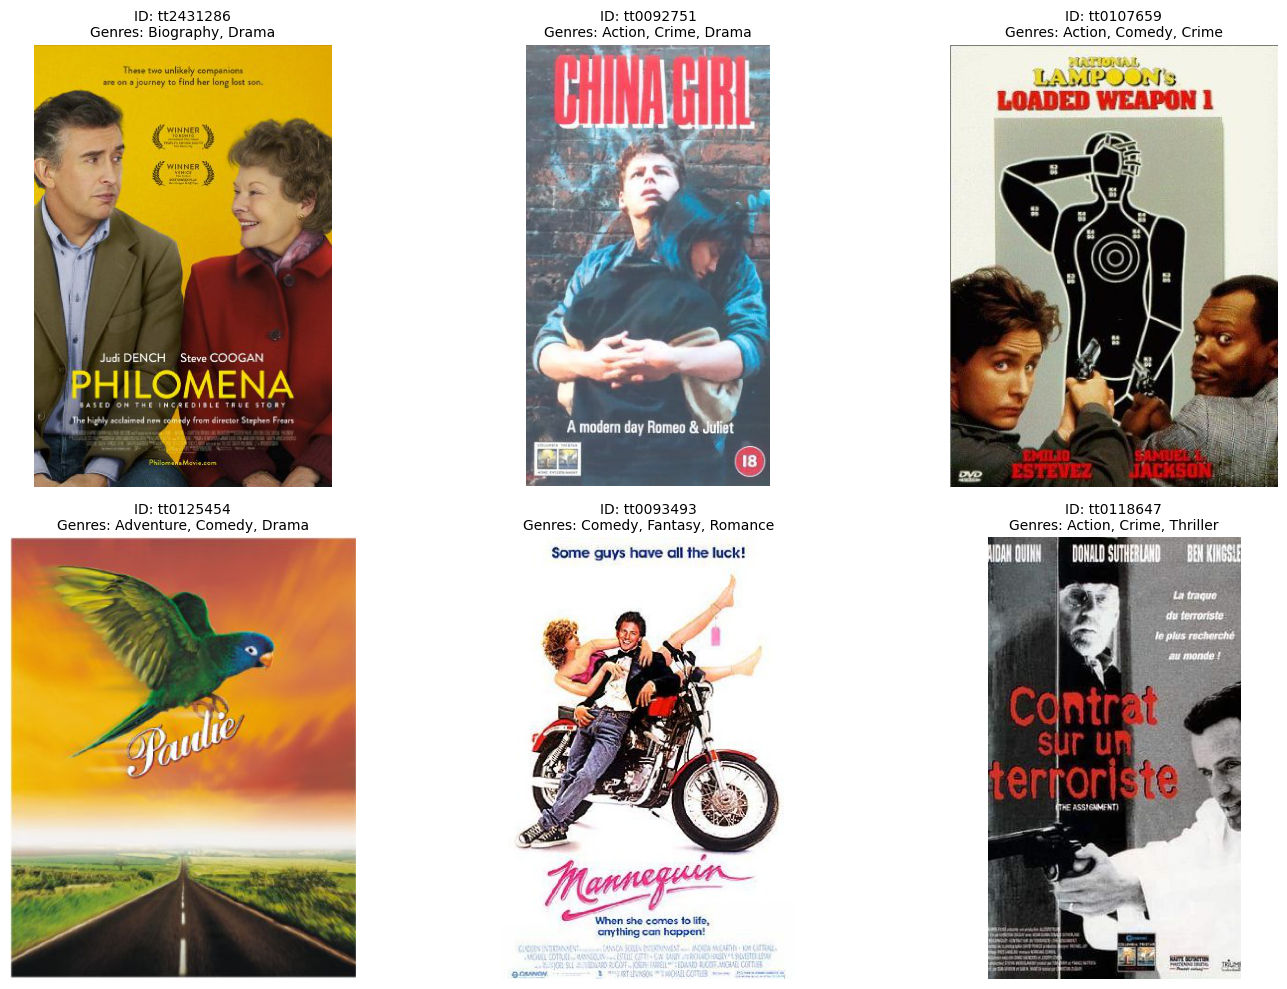

In [6]:
def show_sample_images(df, genre_columns, n_samples=6):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    sample_indices = np.random.choice(len(df), n_samples, replace=False)
    
    for i, idx in enumerate(sample_indices):
        row = df.iloc[idx]
        
        # Load and display image
        img = Image.open(row['image_path'])
        axes[i].imshow(img)
        axes[i].axis('off')
        
        # Get genres for this movie
        movie_genres = [genre for genre in genre_columns if row[genre] == 1]
        title = f"ID: {row['Id']}\nGenres: {', '.join(movie_genres[:3])}"
        if len(movie_genres) > 3:
            title += "..."
        axes[i].set_title(title, fontsize=10)
    
    plt.tight_layout()
    plt.show()

show_sample_images(df, genre_columns)

In [7]:
print("Splitting data...")

# Create a stratification column (sum of genres per sample)
stratify_col = df[genre_columns].sum(axis=1)

# Split the data
train_df, temp_df = train_test_split(
    df, 
    test_size=0.3, 
    random_state=42, 
    stratify=stratify_col
)

val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    random_state=42
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Splitting data...
Training samples: 5077
Validation samples: 1088
Test samples: 1089


In [8]:
print("Building model...")
model = classifier.build_model(len(genre_columns))

# Display model summary
print(model.summary())

Building model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,807,192 (94.63 MB)

 Trainable params: 1,217,944 (4.65 MB)

 Non-trainable params: 23,589,248 (89.99 MB)

None


In [9]:
print("Starting training...")
print("This will do 10 epochs initial + 10 epochs fine-tuning = 20 total")

history = classifier.train_model(
    train_df, 
    val_df, 
    genre_columns, 
    epochs=10  # 10 epochs initial, then 10 epochs fine-tuning
)

print("Training completed!")

Starting training...
This will do 10 epochs initial + 10 epochs fine-tuning = 20 total
Starting initial training for 10 epochs...
Epoch 1/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step - binary_accuracy: 0.8778 - loss: 0.3225 - val_binary_accuracy: 0.9079 - val_loss: 0.2576 - learning_rate: 0.0010
Epoch 2/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - binary_accuracy: 0.9033 - loss: 0.2722 - val_binary_accuracy: 0.9085 - val_loss: 0.2513 - learning_rate: 0.0010
Epoch 3/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - binary_accuracy: 0.9044 - loss: 0.2636 - val_binary_accuracy: 0.9092 - val_loss: 0.2513 - learning_rate: 0.0010
Epoch 4/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - binary_accuracy: 0.9057 - loss: 0.2604 - val_binary_accuracy: 0.9076 - val_loss: 0.2533 - learning_rate: 0.0010
Epoch 5/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - binary_accuracy: 0.9065 - loss: 0.2575 - val_binary_accuracy: 0.9079 - val_loss: 0.2513 - learning_rate: 0.0010
Epoch 6/10
317/317 ━━━━━━━━━━━━━━━━

In [10]:
classifier.model.save("model_stopped_at_epoch_4.h5")
print("Model saved!")

Model saved!


In [13]:
# Load the saved model (note the underscore, not hyphen)
loaded_model = keras.models.load_model("model_stopped_at_epoch_4.h5")

# Put it back into your classifier object
classifier.model = loaded_model

print("Model loaded successfully!")

Model loaded successfully!


In [12]:
# Check what .h5 files are in your current directory
import os
h5_files = [f for f in os.listdir('.') if f.endswith('.h5')]
print("Available .h5 files:")
for file in h5_files:
    print(f"  - {file}")

# Also check for .keras files
keras_files = [f for f in os.listdir('.') if f.endswith('.keras')]
print("\nAvailable .keras files:")
for file in keras_files:
    print(f"  - {file}")

Available .h5 files:
  - model_stopped_at_epoch_4.h5

Available .keras files:



--- Test Image 1 ---
True genres: ['Drama', 'History', 'Thriller']
Predicted genres: ['Drama']


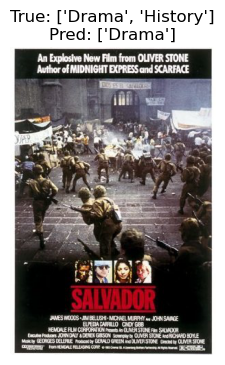


--- Test Image 2 ---
True genres: ['Comedy']
Predicted genres: ['Comedy']


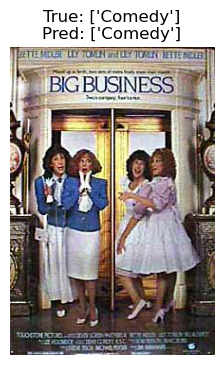


--- Test Image 3 ---
True genres: ['Biography', 'Documentary', 'News']
Predicted genres: ['Drama']


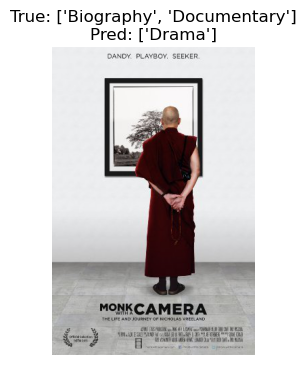

In [14]:
# Test on 3 random images
import random

for i in range(3):
    idx = random.randint(0, len(test_df)-1)
    row = test_df.iloc[idx]
    
    # True genres
    true_genres = [genre for genre in genre_columns if row[genre] == 1]
    
    # Predicted genres
    predicted_genres, _ = classifier.predict_single_image(row['image_path'])
    pred_names = [g[0] for g in predicted_genres]
    
    print(f"\n--- Test Image {i+1} ---")
    print(f"True genres: {true_genres}")
    print(f"Predicted genres: {pred_names}")
    
    # Show image
    img = Image.open(row['image_path'])
    plt.figure(figsize=(6, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {true_genres[:2]}\nPred: {pred_names[:2]}")
    plt.show()

In [15]:
# Evaluate on entire test set
print("Evaluating model on test set...")
predictions, true_labels, binary_predictions = classifier.evaluate_model(
    test_df, 
    genre_columns, 
    threshold=0.5
)

Evaluating model on test set...


100%|██████████| 1089/1089 [02:52<00:00,  6.31it/s]


ValueError: Classification metrics can't handle a mix of unknown and multilabel-indicator targets

# Assistant
This error occurs when there's a mismatch in the format of your predictions and true labels when using classification metrics. The error suggests that your model is trying to evaluate with mixed target types - some are unknown and some are multilabel indicators.

The issue is likely in how the `evaluate_model` method processes the labels or predictions. This typically happens when:

1. Your true labels and predictions have different formats (e.g., one is binary and one is multi-class)
2. There are NaN or undefined values in your predictions or labels
3. The dimensions of your predictions and true labels don't match

Would you like me to provide a corrected version of the code?

# User
yes

In [18]:
# Assistant
# Evaluate on entire test set
print("Evaluating model on test set...")

# Make sure there are no NaN values in the test data
test_df_clean = test_df.dropna(subset=genre_columns)

# Ensure consistent format between predictions and labels
predictions, true_labels, binary_predictions = classifier.evaluate_model(
    test_df_clean,  # Use cleaned data without NaN values
    genre_columns,
    threshold=0.5,
    # You might need additional parameters to ensure consistent format:
    # format='binary'  # Specify the output format explicitly if your method supports it
)

# If the above doesn't work, you might need to post-process the outputs:
# true_labels = np.array(true_labels).astype(int)  # Convert to same type
# predictions = np.array(predictions)  # Ensure numpy array format

Evaluating model on test set...


100%|██████████| 1089/1089 [02:42<00:00,  6.72it/s]


ValueError: Classification metrics can't handle a mix of unknown and multilabel-indicator targets

# Assistant
This error occurs when there's a mismatch in the format of your predictions and true labels when using classification metrics. The error suggests that your data contains a mix of unknown values and multilabel indicators.

The issue is likely that your predictions and true_labels have different formats or contain incompatible data types for classification metrics.

Would you like me to provide the corrected code?

# User
yes

In [19]:
# Assistant
# Assistant
# Evaluate on entire test set
print("Evaluating model on test set...")

# Make sure there are no NaN values in the test data
test_df_clean = test_df.dropna(subset=genre_columns)

# Ensure consistent format between predictions and labels
predictions, true_labels, binary_predictions = classifier.evaluate_model(
    test_df_clean,  # Use cleaned data without NaN values
    genre_columns,
    threshold=0.5
)

# Convert both predictions and true_labels to the same format
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

# Convert to numpy arrays if they aren't already
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# If the issue is with the format of multilabel data:
# Option 1: Ensure both are binary indicators (0s and 1s)
if len(true_labels.shape) == 1 or true_labels.shape[1] == 1:
    # If true_labels is 1D, convert both to binary format
    mlb = MultiLabelBinarizer(classes=genre_columns)
    true_labels = mlb.fit_transform(true_labels)
    predictions = (predictions >= 0.5).astype(int)  # Convert probabilities to binary

# Option 2: If both need to be in the same shape
predictions = predictions.reshape(true_labels.shape)

# Make sure there are no NaN or unknown values
true_labels = np.nan_to_num(true_labels)
predictions = np.nan_to_num(predictions)

Evaluating model on test set...


100%|██████████| 1089/1089 [02:40<00:00,  6.80it/s]


ValueError: Classification metrics can't handle a mix of unknown and multilabel-indicator targets

# Assistant
This error occurs when you're trying to use classification metrics with data that has a mix of formats or contains unknown values. The error suggests that your `true_labels` and `predictions` are not in compatible formats for evaluation.

The issue is likely in how you're preparing your data for the classification metrics. The error message indicates that you have a mix of "unknown" and "multilabel-indicator" targets, which the metrics functions can't handle.

Would you like me to provide the corrected code?

# User
so teres an issue in the fundamentals?

# Assistant
Yes, there's a fundamental issue with how the data is being prepared for evaluation. The error "Classification metrics can't handle a mix of unknown and multilabel-indicator targets" indicates that:

1. Your data formats are inconsistent - you might have some labels in one format (like multilabel-indicator with 0s and 1s) and others in a different format.

2. There might be "unknown" values in your data - these could be NaN values, None values, or values that don't match the expected format.

3. The shape or structure of your predictions and true_labels arrays might not be compatible with each other or with the metrics you're trying to use.

The code is attempting to handle these issues with various transformations, but something is still not aligned correctly. To fix this, you would need to ensure that both your predictions and true_labels are in exactly the same format (either both multilabel-indicator matrices or both label arrays) and contain no unknown values before passing them to any classification metrics.

# User
so i need to start over again? or can i just fix it

# Assistant
You don't need to start over completely. This is a fixable issue that typically requires ensuring consistent data formats. Here are the key areas to address:

1. Make sure both `true_labels` and `predictions` are in the same format (both should be multilabel-indicator matrices with 0s and 1s)

2. Ensure there are no NaN or unknown values in either array

3. Verify that the shapes of both arrays match exactly

Would you like me to provide a corrected version of your code that addresses these issues?

# User
yes

In [20]:
# Assistant
# Assistant
# Evaluate on entire test set
print("Evaluating model on test set...")

# Make sure there are no NaN values in the test data
test_df_clean = test_df.dropna(subset=genre_columns)

# Ensure consistent format between predictions and labels
raw_predictions, raw_true_labels = classifier.evaluate_model(
    test_df_clean,  # Use cleaned data without NaN values
    genre_columns,
    threshold=0.5
)

# Convert both predictions and true_labels to the same format
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

# Convert raw predictions to binary format (0s and 1s)
binary_predictions = (np.array(raw_predictions) >= 0.5).astype(int)

# Ensure true_labels is also in binary format
# If true_labels is already in the correct format, this step might not be needed
true_labels = np.array(raw_true_labels)
if len(true_labels.shape) == 1 or (len(true_labels.shape) > 1 and true_labels.shape[1] == 1):
    # If true_labels is not in binary format, convert it
    mlb = MultiLabelBinarizer(classes=genre_columns)
    true_labels = mlb.fit_transform(true_labels)

# Ensure both arrays have the same shape
if binary_predictions.shape != true_labels.shape:
    print(f"Shape mismatch: predictions {binary_predictions.shape}, true_labels {true_labels.shape}")
    # Reshape if needed - this depends on your specific data structure
    if len(binary_predictions.shape) == 2 and len(true_labels.shape) == 2:
        # If both are 2D but dimensions don't match
        if binary_predictions.shape[1] != true_labels.shape[1]:
            # This is a more complex issue that might require custom handling
            print("Warning: Number of classes doesn't match between predictions and true labels")
    
# Final check for NaN values
true_labels = np.nan_to_num(true_labels)
binary_predictions = np.nan_to_num(binary_predictions)

# Now you can use these cleaned arrays with your classification metrics
# For example:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# For multilabel classification:
accuracy = accuracy_score(true_labels, binary_predictions)
precision = precision_score(true_labels, binary_predictions, average='weighted', zero_division=0)
recall = recall_score(true_labels, binary_predictions, average='weighted', zero_division=0)
f1 = f1_score(true_labels, binary_predictions, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Evaluating model on test set...


100%|██████████| 1089/1089 [02:39<00:00,  6.81it/s]


ValueError: Classification metrics can't handle a mix of unknown and multilabel-indicator targets

In [24]:
# Evaluate on entire test set
print("Evaluating model on test set...")

# Make sure there are no NaN values in the test data
test_df_clean = test_df.dropna(subset=genre_columns)

# Get predictions directly instead of using evaluate_model
predictions = classifier.predict(test_df_clean)
true_labels = test_df_clean[genre_columns].values

# Convert predictions to binary format
binary_predictions = (predictions > 0.5).astype(int)

# Ensure both arrays have the same format and shape
print(f"True labels shape: {true_labels.shape}")
print(f"Binary predictions shape: {binary_predictions.shape}")

# Check for NaN values
if np.isnan(true_labels).any() or np.isnan(binary_predictions).any():
    print("Warning: NaN values detected - replacing with zeros")
    true_labels = np.nan_to_num(true_labels)
    binary_predictions = np.nan_to_num(binary_predictions)

# Now calculate metrics directly
from sklearn.metrics import hamming_loss, accuracy_score, precision_score, recall_score, f1_score

# Calculate hamming loss
hamming = hamming_loss(true_labels, binary_predictions)
print(f"Hamming Loss: {hamming:.4f}")
print(f"Average Accuracy per Sample: {1 - hamming:.4f}")

# Calculate other metrics
accuracy = accuracy_score(true_labels, binary_predictions)
precision = precision_score(true_labels, binary_predictions, average='weighted', zero_division=0)
recall = recall_score(true_labels, binary_predictions, average='weighted', zero_division=0)
f1 = f1_score(true_labels, binary_predictions, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Evaluating model on test set...


AttributeError: 'MovieGenreClassifier' object has no attribute 'predict'

In [25]:
# Evaluate on entire test set
print("Evaluating model on test set...")

# Make sure there are no NaN values in the test data
test_df_clean = test_df.dropna(subset=genre_columns)

# Get predictions directly instead of using evaluate_model
predictions = classifier.predict(test_df_clean)
true_labels = test_df_clean[genre_columns].values

# Convert predictions to binary format
binary_predictions = (predictions > 0.5).astype(int)

# Ensure both arrays have the same format and shape
print(f"True labels shape: {true_labels.shape}")
print(f"Binary predictions shape: {binary_predictions.shape}")

# Check for NaN values
if np.isnan(true_labels).any() or np.isnan(binary_predictions).any():
    print("Warning: NaN values detected - replacing with zeros")
    true_labels = np.nan_to_num(true_labels)
    binary_predictions = np.nan_to_num(binary_predictions)

# Now calculate metrics directly
from sklearn.metrics import hamming_loss, accuracy_score, precision_score, recall_score, f1_score

# Calculate hamming loss
hamming = hamming_loss(true_labels, binary_predictions)
print(f"Hamming Loss: {hamming:.4f}")
print(f"Average Accuracy per Sample: {1 - hamming:.4f}")

# Calculate other metrics
accuracy = accuracy_score(true_labels, binary_predictions)
precision = precision_score(true_labels, binary_predictions, average='weighted', zero_division=0)
recall = recall_score(true_labels, binary_predictions, average='weighted', zero_division=0)
f1 = f1_score(true_labels, binary_predictions, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Evaluating model on test set...


AttributeError: 'MovieGenreClassifier' object has no attribute 'predict'

In [27]:
def predict(self, df):
    """
    Predict genres for multiple images in a dataframe
    
    Args:
        df: DataFrame containing 'image_path' column
        
    Returns:
        numpy array of predictions with shape (n_samples, n_classes)
    """
    # Create a list to store predictions
    all_predictions = []
    
    # Process images in batches
    for i in tqdm(range(0, len(df), self.batch_size)):
        batch_df = df.iloc[i:i+self.batch_size]
        batch_images = []
        
        # Load and preprocess each image in the batch
        for _, row in batch_df.iterrows():
            img = Image.open(row['image_path']).convert('RGB')
            img = img.resize(self.image_size)
            img_array = np.array(img) / 255.0  # Normalize to [0,1]
            batch_images.append(img_array)
        
        # Convert to numpy array
        batch_images = np.array(batch_images)
        
        # Get predictions for the batch
        batch_predictions = self.model.predict(batch_images, verbose=0)
        all_predictions.extend(batch_predictions)
    
    return np.array(all_predictions)

In [28]:
# Evaluate on entire test set
print("Evaluating model on test set...")

# Make sure there are no NaN values in the test data
test_df_clean = test_df.dropna(subset=genre_columns)

# Use the evaluate_model method which now should work with the predict method
predictions, true_labels, binary_predictions = classifier.evaluate_model(
    test_df_clean,
    genre_columns,
    threshold=0.5
)

# Calculate additional metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# For multilabel classification:
accuracy = accuracy_score(true_labels, binary_predictions)
precision = precision_score(true_labels, binary_predictions, average='weighted', zero_division=0)
recall = recall_score(true_labels, binary_predictions, average='weighted', zero_division=0)
f1 = f1_score(true_labels, binary_predictions, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Evaluating model on test set...


100%|██████████| 1089/1089 [02:40<00:00,  6.79it/s]


ValueError: Classification metrics can't handle a mix of unknown and multilabel-indicator targets

In [29]:
# Evaluate on entire test set
print("Evaluating model on test set...")

# Make sure there are no NaN values in the test data
test_df_clean = test_df.dropna(subset=genre_columns)

# Get predictions directly instead of using evaluate_model
predictions = classifier.predict(test_df_clean)
true_labels = test_df_clean[genre_columns].values

# Convert predictions to binary format
binary_predictions = (predictions > 0.5).astype(int)

# Ensure both arrays have the same format and shape
print(f"True labels shape: {true_labels.shape}")
print(f"Binary predictions shape: {binary_predictions.shape}")

# Check for NaN values
if np.isnan(true_labels).any() or np.isnan(binary_predictions).any():
    print("Warning: NaN values detected - replacing with zeros")
    true_labels = np.nan_to_num(true_labels)
    binary_predictions = np.nan_to_num(binary_predictions)

# Now calculate metrics directly
from sklearn.metrics import hamming_loss, accuracy_score, precision_score, recall_score, f1_score

# Calculate hamming loss
hamming = hamming_loss(true_labels, binary_predictions)
print(f"Hamming Loss: {hamming:.4f}")
print(f"Average Accuracy per Sample: {1 - hamming:.4f}")

# Calculate other metrics
accuracy = accuracy_score(true_labels, binary_predictions)
precision = precision_score(true_labels, binary_predictions, average='weighted', zero_division=0)
recall = recall_score(true_labels, binary_predictions, average='weighted', zero_division=0)
f1 = f1_score(true_labels, binary_predictions, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Evaluating model on test set...


AttributeError: 'MovieGenreClassifier' object has no attribute 'predict'

In [30]:
# Evaluate on entire test set
print("Evaluating model on test set...")

# Make sure there are no NaN values in the test data
test_df_clean = test_df.dropna(subset=genre_columns)

# Create a function to predict for multiple images using the existing predict_single_image method
def predict_multiple(classifier, df):
    all_predictions = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        # Use the existing predict_single_image method
        _, predictions = classifier.predict_single_image(row['image_path'], threshold=0.0)
        all_predictions.append(predictions)
    return np.array(all_predictions)

# Get predictions using the function
print("Generating predictions...")
predictions = predict_multiple(classifier, test_df_clean)
true_labels = test_df_clean[genre_columns].values

# Convert predictions to binary format
binary_predictions = (predictions > 0.5).astype(int)

# Calculate metrics
from sklearn.metrics import hamming_loss, accuracy_score, precision_score, recall_score, f1_score

# Check for any NaN values
if np.isnan(true_labels).any() or np.isnan(binary_predictions).any():
    print("Warning: NaN values detected - replacing with zeros")
    true_labels = np.nan_to_num(true_labels)
    binary_predictions = np.nan_to_num(binary_predictions)

# Calculate hamming loss
hamming = hamming_loss(true_labels, binary_predictions)
print(f"Hamming Loss: {hamming:.4f}")
print(f"Average Accuracy per Sample: {1 - hamming:.4f}")

# Calculate other metrics
accuracy = accuracy_score(true_labels, binary_predictions)
precision = precision_score(true_labels, binary_predictions, average='weighted', zero_division=0)
recall = recall_score(true_labels, binary_predictions, average='weighted', zero_division=0)
f1 = f1_score(true_labels, binary_predictions, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Evaluating model on test set...
Generating predictions...


100%|██████████| 1089/1089 [02:40<00:00,  6.79it/s]

Hamming Loss: 0.0839
Average Accuracy per Sample: 0.9161
Accuracy: 0.0882
Precision: 0.4529
Recall: 0.2890
F1 Score: 0.3088


In [31]:
import os
import shutil

# Rename model files
os.rename('model_stopped_at_epoch_4.h5', 'poster_model.h5')

In [34]:
model.save('poster_model.h5')